In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train_file = "./train.csv"
test_file = "./test.csv"

In [3]:
def preprocess(train_file, test_file):
    dfTrain = pd.read_csv(train_file)
    dfTest = pd.read_csv(test_file)
    df = pd.concat([dfTrain,dfTest], sort=False)
    
    num_cols = ["ps_reg_01", "ps_reg_02", "ps_reg_03","ps_car_12", "ps_car_13", "ps_car_14", "ps_car_15"]
    ignore_cols = ["id", "target", "ps_calc_01", "ps_calc_02", "ps_calc_03", "ps_calc_04", "ps_calc_05", 
                   "ps_calc_06", "ps_calc_07", "ps_calc_08", "ps_calc_09", "ps_calc_10", "ps_calc_11", 
                   "ps_calc_12", "ps_calc_13", "ps_calc_14","ps_calc_15_bin", "ps_calc_16_bin", 
                   "ps_calc_17_bin","ps_calc_18_bin", "ps_calc_19_bin", "ps_calc_20_bin"]
    
    field_size = len(df.columns) - len(ignore_cols)
    feature_dict = {}
    feature_size = 0
    for col in df.columns:
        if col in ignore_cols:
            continue
        elif col in num_cols:
            feature_dict[col] = feature_size
            feature_size += 1
        else:
            unique_val = df[col].unique()
            feature_dict[col] = dict(zip(unique_val,range(feature_size,len(unique_val) + feature_size)))
            feature_size += len(unique_val)

    def transform(raw_df):
        label = raw_df[['target']]
        raw_df.drop(['target','id'],axis=1,inplace=True)

        feature_idx = raw_df.copy()
        feature_val = raw_df.copy()
        for col in feature_idx.columns:
            if col in ignore_cols:
                feature_idx.drop(col,axis=1,inplace=True)
                feature_val.drop(col,axis=1,inplace=True)
                continue
            elif col in num_cols:
                feature_idx[col] = feature_dict[col]
            else:
                feature_idx[col] = feature_idx[col].map(feature_dict[col])
                feature_val[col] = 1
        return tf.data.Dataset.from_tensor_slices((feature_idx.values, feature_val.values, label.values))

    return field_size, feature_size, transform(dfTrain)

In [4]:
class DeepFM(tf.keras.Model):
    def __init__(self, cfg):
        super(DeepFM, self).__init__()
        self.feature_size = cfg['feature_size']
        self.field_size = cfg['field_size']
        self.embed_size = cfg['embed_size']
        self.deep_nn = cfg['deep_nn']
        
        self.dropout_fm = cfg['dropout_fm']
        self.dropout_deep = cfg['dropout_deep']
        
        # fm        
        self.feature_weight = tf.keras.layers.Embedding(cfg['feature_size'], 1)
        self.feature_embed = tf.keras.layers.Embedding(cfg['feature_size'], cfg['embed_size'])

        # dnn
        for layer in range(len(cfg['deep_nn'])):
            setattr(self, 'dense_' + str(layer), tf.keras.layers.Dense(self.deep_nn[layer]))
            setattr(self, 'batchNorm_' + str(layer), tf.keras.layers.BatchNormalization())
            setattr(self, 'activation_' + str(layer), tf.keras.layers.Activation('relu'))
            setattr(self, 'dropout_' + str(layer), tf.keras.layers.Dropout(self.dropout_deep))
            
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True)

    def call(self, feature_idx, feature_val):
        reshaped_feature_val = tf.cast(tf.reshape(feature_val, shape=[-1,self.field_size,1]), tf.float32)
        # linear        
        weights = self.feature_weight(feature_idx)
        linear = tf.reduce_sum(tf.multiply(weights,reshaped_feature_val),2)
        
        # fm  
        embeddings = self.feature_embed(feature_idx)
        second_inner = tf.multiply(embeddings,reshaped_feature_val)
        
        summed_features_emb = tf.reduce_sum(second_inner,1)
        summed_features_emb_square = tf.square(summed_features_emb)
        
        squared_features_emb = tf.square(second_inner)
        squared_sum_features_emb = tf.reduce_sum(squared_features_emb,1)
        
        fm = 0.5 * tf.subtract(summed_features_emb_square,squared_sum_features_emb)
        
        # dnn
        y_deep = tf.reshape(embeddings,shape=[-1,self.field_size * self.embed_size])
        for layer in range(0, len(self.deep_nn)):
            y_deep = getattr(self, 'dense_' + str(layer))(y_deep)
            y_deep = getattr(self, 'batchNorm_' + str(layer))(y_deep)
            y_deep = getattr(self, 'activation_' + str(layer))(y_deep)
            y_deep = getattr(self, 'dropout_' + str(layer))(y_deep)
            
        # concat
        concat = tf.concat([linear, fm, y_deep], axis=1)                                
        out = self.fc(concat)
        return out

In [5]:
def fit(input, cfg):
    model = DeepFM(cfg)
    loss_val = []
    train = input.shuffle(10000).batch(cfg['batch'])
    for epoch in range(int(cfg['epoch'])):
        batch_idx = 0
        for idx, val, label in train:
            with tf.GradientTape() as tape:
                y = model(idx, val)
                bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
                loss = bce(y_true=label, y_pred=y)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            batch_idx += 1
            # tf.print('batch_idx:', batch_idx, 'loss:', loss)
        loss_val.append(loss)
        tf.print("Epoch {}/{}　Loss: {}".format(epoch, cfg['epoch'], loss))
    return loss_val

In [6]:
field_size, feature_size, train = preprocess(train_file, test_file)

In [7]:
cfg = {
    "feature_size": feature_size,
    "field_size": field_size,
    "embed_size":8,
    "deep_nn":[32,32],
    "dropout_fm": 0,
    "dropout_deep": 0.2,
    "epoch":20,
    "batch":10000
}

In [8]:
loss_val = fit(train, cfg)

Epoch 0/20　Loss: 0.9228009581565857
Epoch 1/20　Loss: 0.8883423209190369
Epoch 2/20　Loss: 0.8454411625862122
Epoch 3/20　Loss: 0.8008630275726318
Epoch 4/20　Loss: 0.7582089900970459
Epoch 5/20　Loss: 0.7258159518241882
Epoch 6/20　Loss: 0.7061982154846191
Epoch 7/20　Loss: 0.6972800493240356
Epoch 8/20　Loss: 0.6941609382629395
Epoch 9/20　Loss: 0.6933595538139343
Epoch 10/20　Loss: 0.6931925415992737
Epoch 11/20　Loss: 0.6931597590446472
Epoch 12/20　Loss: 0.6931519508361816
Epoch 13/20　Loss: 0.6931494474411011
Epoch 14/20　Loss: 0.6931486129760742
Epoch 15/20　Loss: 0.693148136138916
Epoch 16/20　Loss: 0.6931477785110474
Epoch 17/20　Loss: 0.6931476593017578
Epoch 18/20　Loss: 0.6931475400924683
Epoch 19/20　Loss: 0.6931475400924683


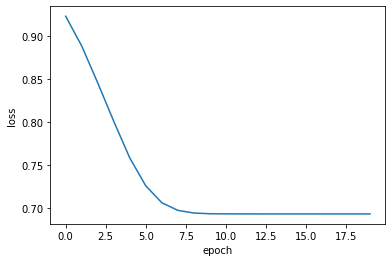

In [9]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot([i for i in range(cfg['epoch'])], loss_val)
plt.show()